In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import kstest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import time
plt.rcParams['font.family'] = ['Arial Unicode MS'] #正常显示中文
%matplotlib inline
warnings.filterwarnings('ignore') 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

def pd_all():
    pd.set_option('display.max_rows', None)#显示全部行
    pd.set_option('display.max_columns', None)#显示全部列

def pd_def():
    pd.set_option('display.max_rows', 10)#恢复默认显示行数
    pd.set_option('display.max_columns', 10)#恢复默认显示行数

## 数据特征解释
* _MODE  表示标准化信息众数
* _AVG 表示平均值
* _MEDI 标准化信息的中位数
* 

In [2]:
data=pd.read_csv(r'../Dataset/application_train.csv')

In [3]:
data.shape

(307511, 122)

In [4]:
print('1样本数为：{}'.format(data.TARGET.sum()))
print('总样本数为：{}'.format(data.shape[0]))
print('少数类样本占总样本数比例：{:.5f}'.format(data.TARGET.sum()/data.shape[0]))

1样本数为：24825
总样本数为：307511
少数类样本占总样本数比例：0.08073


In [5]:
#  查看 SK_ID_CURR 是否在数据集中是唯一的
len(data['SK_ID_CURR'].unique())
data.drop('SK_ID_CURR',axis=1,inplace=True) # SK_ID_CURR 对预测无影响

307511

## 填补缺失值
特殊点：
* 数据中有许多特征明显直接相关，他们大多数为中间指标，不能直接按缺失超过0.45的方式删除
* 这些中间指标中，连续变量可以通过LR进行填补，离散变量可以通过随机森林得到补全，填补这些特征的数据使用与他们有直接相关关系的数据，进而加快填补速度及避免过多噪声

In [6]:
# # 此模块的全局变量
rate = 0.45 # 判定为严重缺失的阈值
rate = 1- rate

In [7]:
# 检查缺失数据整体情况
def examine_missing_data(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (100 * df.isnull().sum() / len(df)).sort_values(ascending=False)
    missing_table = pd.concat([missing, missing_percent], axis=1)
    missing_table = missing_table.rename(columns={0: '缺失值数量', 1: '缺失值占比(%)'})
    missing_table = missing_table[missing_table.iloc[:, 1] != 0]
    print("数据总共有%d个特征，其中存在缺失值的特征数为%d" % (df.shape[1], missing_table.shape[0]))
    return missing_table


missing_values = examine_missing_data(data)
pd_all()
temp = missing_values
temp
pd_def()
# temp.to_csv('../Result/缺失值情况表.csv')

数据总共有121个特征，其中存在缺失值的特征数为67


,缺失值数量,缺失值占比(%)
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [8]:
# 缺失值超过阈值的特征
cols = set(data[data.isnull()]) - set(data.dropna(thresh=data.shape[0]*rate,axis=1).columns)
print('缺失值超过{}的特征一共有{}个'.format(rate,len(cols)))

# 缺失值大部分是一些中间指标 以 AVG、MODE、MODI 为后缀，这些值中的连续变量明显有着线性关系，可以通过LR进行补全
zj_cols = data[cols].filter(regex = '_AVG|_MODE|_MEDI').columns
# data.filter(regex = '_AVG|_MODE|_MEDI').shape[1] # 47, 缺失的大部分数据是中间值
print('为中间指标的特征一共有{}个，为:\n'.format(len(zj_cols)),zj_cols)
not_zj_cols = set(cols) - set(zj_cols)
print('非中间指标的特征一共有{}个，为:\n'.format(len(not_zj_cols)),not_zj_cols)

缺失值超过0.55的特征一共有49个
为中间指标的特征一共有47个，为:
 Index(['BASEMENTAREA_MODE', 'FONDKAPREMONT_MODE', 'FLOORSMIN_MODE',
       'ELEVATORS_MODE', 'NONLIVINGAREA_AVG', 'BASEMENTAREA_MEDI',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE',
       'LIVINGAPARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'LANDAREA_AVG',
       'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'FLOORSMIN_MEDI',
       'YEARS_BUILD_MEDI', 'NONLIVINGAPARTMENTS_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'COMMONAREA_MODE', 'ELEVATORS_MEDI',
       'YEARS_BUILD_MODE', 'LIVINGAREA_AVG', 'YEARS_BUILD_AVG',
       'HOUSETYPE_MODE', 'NONLIVINGAPARTMENTS_MODE', 'APARTMENTS_MODE',
       'ELEVATORS_AVG', 'LIVINGAPARTMENTS_MODE', 'FLOORSMAX_MEDI',
       'WALLSMATERIAL_MODE', 'NONLIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI',
       'ENTRANCES_AVG', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'ENTRANCES_MODE',
       'FLOORSMAX_MODE', 'COMMONAREA_MEDI', 'FLOORSMAX_AVG',
       'LIVINGAPARTMENTS_AVG', 'APARTMENTS_MEDI', 'FLOOR

In [9]:
# 查看这些缺失率高于阈值的中间变量的数据类型，确定处理方案
print('这些缺失超过{}的中间指标的数据类型分布为：\n'.format(rate),data[zj_cols].dtypes.value_counts())
print('其中， object 类型特征为',data[zj_cols].select_dtypes('object').columns)
ls_cols = [ i for i in zj_cols if len(data[i].unique())<10 ] 
print('这些中间指标的离散变量为:', [ i for i in zj_cols if len(data[i].unique())<10 ])
# 这些缺失率高于阈值的中间指标中，只有 FONDKAPREMONT_MODE 为非连续变量，故先处理
# 这些变量中， object变量 和 不同值数量小于10的变量 相同，都是离散变量，所以：
ls_cols = data[zj_cols].select_dtypes('object').columns # 离散变量

这些缺失超过0.55的中间指标的数据类型分布为：
 float64    43
object      4
dtype: int64
其中， object 类型特征为 Index(['FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE'],
      dtype='object')
这些中间指标的离散变量为: ['FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']


In [10]:
# # 处理 FONDKAPREMONT_MODE
# # 信息增益只能用于计算离散变量
#定义计算信息熵的函数：计算Infor(D)
def infor(df):
    a = pd.value_counts(df) / len(df)
    return sum(np.log2(a) * a * (-1))

#定义计算信息增益的函数：计算g(D|A)
def g(df,str1,str2):
    e1 = df.groupby(str1).apply(lambda x:infor(x[str2]))
    p1 = pd.value_counts(df[str1]) / len(df[str1])
    #计算Infor(D|A)
    e2 = sum(e1 * p1)
    return infor(df[str2]) - e2

#定义计算信息增益率的函数：计算gr(D,A)
def gr(df,str1,str2):
    return g(df,str1,str2)/infor(df[str1])


gr(data,'TARGET','TARGET')
for i in ls_cols:
    print(i)
    print('{} 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：'.format(i))
    gr(data.fillna(value={i:'unknown'}), i, 'TARGET')

    _mode = data[i].mode()[0]
    print('{} 使用众数"{}"填充，信息增益率为：'.format(i, _mode))
    gr(data.fillna(value={i:_mode}), i, 'TARGET') 

    print('{} 去除空值时，信息增益率为：'.format(i))
    gr(data.dropna(axis = 0,subset =[i]),i,'TARGET')
    

1.0

FONDKAPREMONT_MODE
FONDKAPREMONT_MODE 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：


0.0005408355860124634

FONDKAPREMONT_MODE 使用众数"reg oper account"填充，信息增益率为：


0.0004201841877809218

FONDKAPREMONT_MODE 去除空值时，信息增益率为：


0.00011110972824071554

EMERGENCYSTATE_MODE
EMERGENCYSTATE_MODE 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：


0.0012179757926267887

EMERGENCYSTATE_MODE 使用众数"No"填充，信息增益率为：


0.00024843185362254355

EMERGENCYSTATE_MODE 去除空值时，信息增益率为：


0.0008944513394649919

HOUSETYPE_MODE
HOUSETYPE_MODE 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：


0.0011184840833877421

HOUSETYPE_MODE 使用众数"block of flats"填充，信息增益率为：


0.00024106565940932044

HOUSETYPE_MODE 去除空值时，信息增益率为：


0.0007992823186348557

WALLSMATERIAL_MODE
WALLSMATERIAL_MODE 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：


0.0007852123859099351

WALLSMATERIAL_MODE 使用众数"Panel"填充，信息增益率为：


0.0002346305338449944

WALLSMATERIAL_MODE 去除空值时，信息增益率为：


0.00037983116255492293

In [11]:
data.shape

(307511, 121)

In [12]:
# 【地板材质】 WALLSMATERIAL_MODE 使用'unknown'替代空值，其信息增益率0.0007852多于使用众数进行填充的信息增益率
# data 中含有WALL关键字的中间变量只有这一个
data.fillna(value={'WALLSMATERIAL_MODE':'unknown'},inplace = True)
data.rename({'WALLSMATERIAL_MODE':'WALLSMATERIAL'},axis=1,inplace=True)

# 【预警情况】EMERGENCYSTATE_MODE 使用众数'No'替代空值，信息增益率0.000248大于使用unknown替代（0.00122）只有 No / Yes 的情况
data.fillna(value={'EMERGENCYSTATE_MODE':'No'},inplace=True)
data.rename({'EMERGENCYSTATE_MODE':'EMERGENCYSTATE'},axis=1,inplace=True)

# 【房屋类型：连栋()/公寓楼(block of flats)/独栋(specific housing)】HOUSETYPE_MODE 使用众数 block of flats 替代空值
data.fillna(value={'HOUSETYPE_MODE':'block of flats'},inplace=True)
data.rename({'HOUSETYPE_MODE':'HOUSETYPE'},axis=1,inplace=True)

# 【账号情况】 FONDKAPREMONT_MODE 使用'unknown'信息增益率更高，但是差距不大：0.00054（unknown） / 0.00042（众数）
data.fillna(value={'FONDKAPREMONT_MODE':'unknown'},inplace=True)
data.rename({'FONDKAPREMONT_MODE':'FONDKAPREMONT'},axis=1,inplace=True)

In [13]:
data.shape

(307511, 121)

In [14]:
# data.filter(regex='WALLSMATERIAL_MODE').columns
# data.filter(regex='EMERGENCYSTATE_MODE').columns
# data.filter(regex='HOUSETYPE').columns
# data.filter(regex='FONDKAPREMONT_MODE').columns
# # 所有离散中间值都只有众数

In [15]:
# 处理上述中间指标中的连续变量
lx_cols = set(zj_cols) - set(ls_cols) # 中间值中的连续变量
print('待处理的连续中间变量：\n',lx_cols)
print('一共有{}个'.format(len(lx_cols)))

待处理的连续中间变量：
 {'BASEMENTAREA_MODE', 'FLOORSMIN_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG', 'BASEMENTAREA_MEDI', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAPARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'LANDAREA_AVG', 'TOTALAREA_MODE', 'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'NONLIVINGAPARTMENTS_AVG', 'COMMONAREA_MODE', 'ELEVATORS_MEDI', 'LIVINGAREA_AVG', 'YEARS_BUILD_AVG', 'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'APARTMENTS_MODE', 'ELEVATORS_AVG', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE', 'FLOORSMAX_MEDI', 'NONLIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'ENTRANCES_AVG', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'COMMONAREA_MEDI', 'FLOORSMAX_AVG', 'LIVINGAPARTMENTS_AVG', 'APARTMENTS_MEDI', 'FLOORSMIN_AVG', 'ENTRANCES_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'COMMONAREA_AVG', 'YEARS_BUILD_MODE', 'LIVINGAREA_MEDI'}
一共有43个


In [16]:
set(lx_cols) - set(data.filter(regex='BUILD|FLOOR|ELEVATORS|AREA|ENTRANCES|BEGINEXPLUATATION|NONLIVINGAPARTMENT|NONLIVINGAREA|^LIVINGAPARTMENT|^LIVINGAREA|^APARTMENT')) # 和连续变量 lx_cols 等价

set()

In [17]:
# 填补连续型中间变量的缺失值
# 这些连续变量的空值使用均值填补
for i in lx_cols:
    data[i].fillna(data[i].mean(),inplace=True)
data[lx_cols].isnull().sum().sum()
# # 处理好连续型中间变量（中间变量都大量缺失，其实是处理好大量缺失的变量中的连续型中间变量）

0

In [18]:
data.shape

(307511, 121)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = BUILD, 匹配属性有：
 Index(['YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI'], dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = FLOOR, 匹配属性有：
 Index(['FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI'],
      dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = ELEVATORS, 匹配属性有：
 Index(['ELEVATORS_AVG', 'ELEVATORS_MODE', 'ELEVATORS_MEDI'], dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = ENTRANCES, 匹配属性有：
 Index(['ENTRANCES_AVG', 'ENTRANCES_MODE', 'ENTRANCES_MEDI'], dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = BEGINEXPLUATATION, 匹配属性有：
 Index(['YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI'],
      dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = BASEMENTAREA, 匹配属性有：
 Index(['BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI'], dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = COMMONAREA, 匹配属性有：
 Index(['COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI'], dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = LANDAREA, 匹配属性有：
 Index(['LANDAREA_AVG', 'LANDAREA_MODE', 'LANDAREA_MEDI'], dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = ^LIVINGAREA, 匹配属性有：
 Index(['LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI'], dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = NONLIVINGAREA, 匹配属性有：
 Index(['NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI'], dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = TOTALAREA, 匹配属性有：
 Index(['TOTALAREA_MODE'], dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = ^LIVINGAPARTMENT, 匹配属性有：
 Index(['LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAPARTMENTS_MEDI'],
      dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = NONLIVINGAPARTMENT, 匹配属性有：
 Index(['NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')


<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = ^APARTMENT, 匹配属性有：
 Index(['APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI'], dtype='object')


<AxesSubplot:>

一共有43个特征


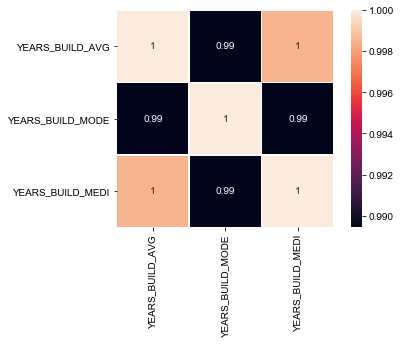

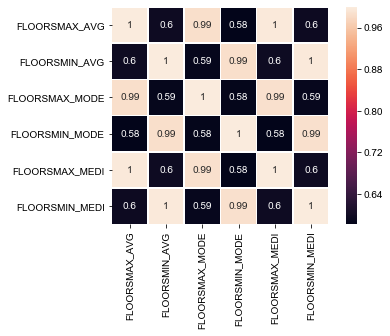

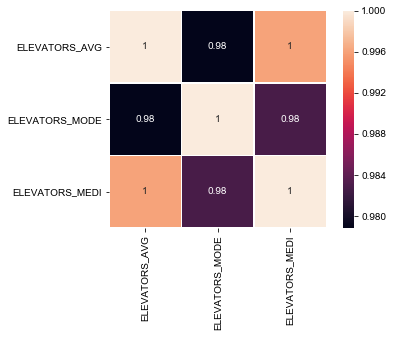

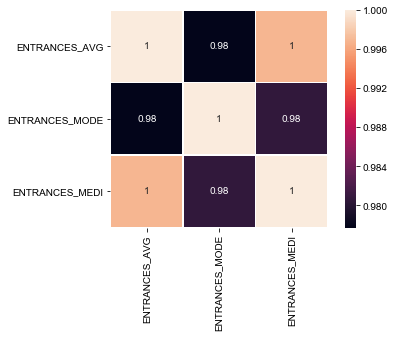

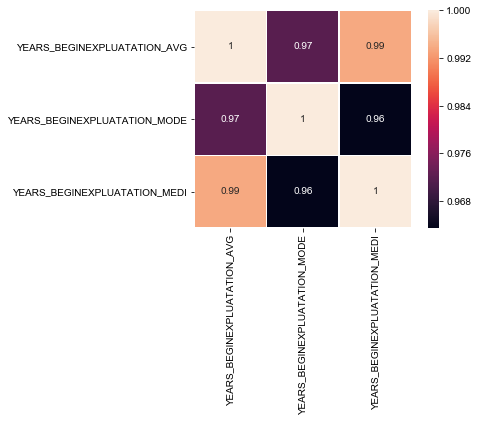

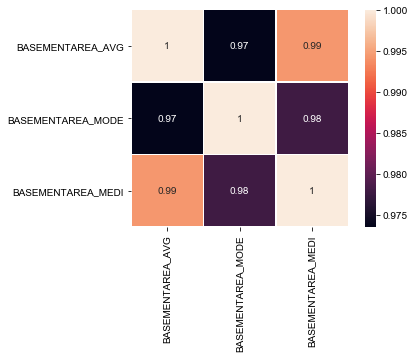

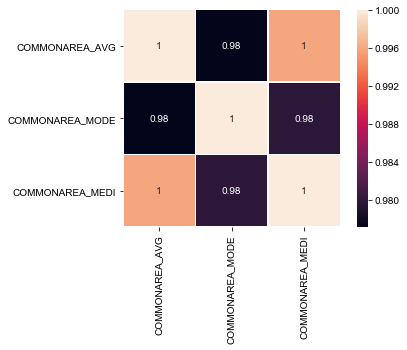

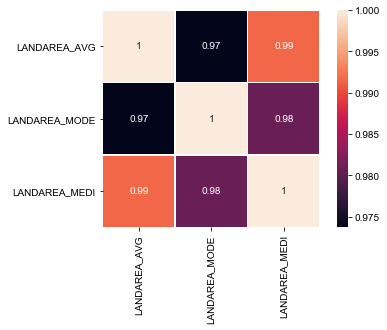

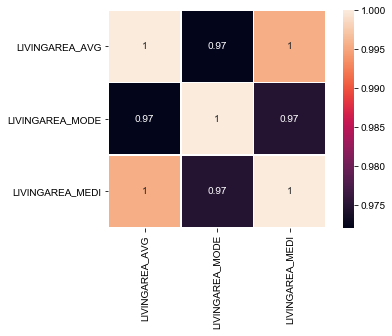

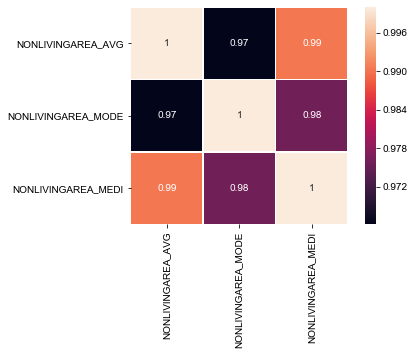

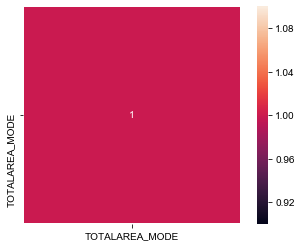

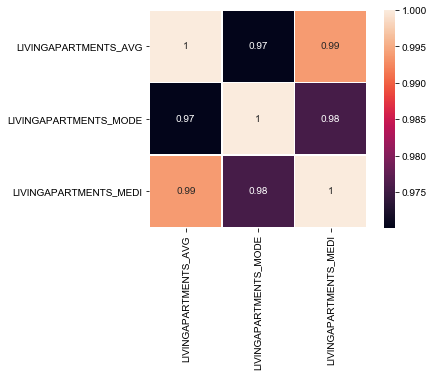

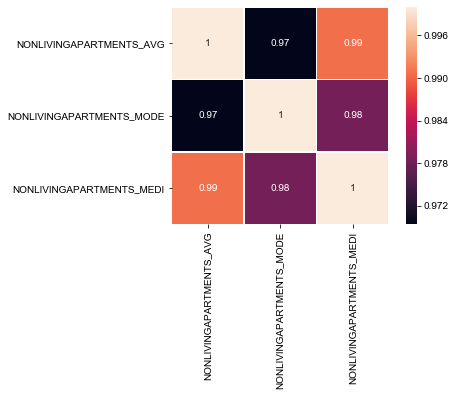

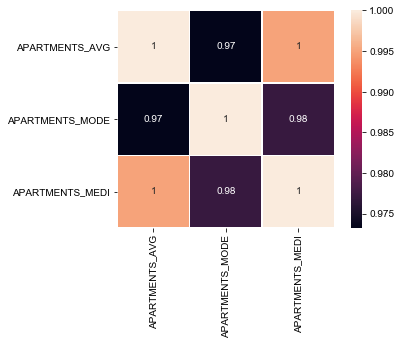

In [19]:
# # 下面处理离散型中间变量
# 关于居住环境的特征
# _regex_str = 'BUILD|FLOOR|ELEVATORS|BASEMENTAREA|NONLIVINGAPARTMENT|NONLIVINGAREA|^LIVINGAPARTMENT|^LIVINGAREA|^APARTMENT'
_regex_str = 'BUILD|FLOOR|ELEVATORS|ENTRANCES|BEGINEXPLUATATION'
area_regex = '|BASEMENTAREA|COMMONAREA|LANDAREA|^LIVINGAREA|NONLIVINGAREA|TOTALAREA'
apar_regex = '|^LIVINGAPARTMENT|NONLIVINGAPARTMENT|^APARTMENT'
_regex_str += area_regex + apar_regex
_regex =  _regex_str.split('|') 
# 细分之后有了更好的效果
cn = 0
for rx in _regex:
    plt.subplots()
    matir = data.filter(regex = rx).corr()
    cn += matir.shape[0]
    print('regex = {}, 匹配属性有：\n'.format(rx),matir.columns) 
    
    sns.heatmap(matir,square=True,linewidths=.5,annot=True)
print('一共有{}个特征'.format(cn))

In [23]:
def draw_pie(df,attr,target):
    '''
    绘制object属性中违约属性占比
    :param df: 数据
    :param attr:
    :param target:
    :return:每项属性值的违约的概率占比
    '''
    tmp = df.groupby([attr,target]).count().iloc[:,0]
    tmp = pd.DataFrame(tmp)
    first_col = tmp.columns[0]

    df_sum = pd.DataFrame(tmp.groupby([attr]).sum()).rename(columns = {first_col:'sum'})
    tmp = tmp.reset_index()
    tmp = pd.merge(tmp,df_sum,on=[attr])
    tmp['mean'] = tmp[first_col]/tmp['sum']
    tmp = tmp[tmp[target]==1]
    # print(tmp)
    plt.pie(tmp['mean']/tmp['mean'].sum(),labels = tmp[attr])
    plt.title(attr)
    plt.show()
    return tmp

缺失房屋信息的客户明显有更大的可能违约


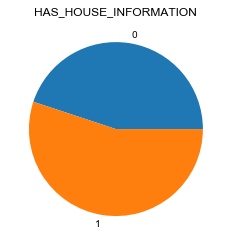

,HAS_HOUSE_INFORMATION,TARGET,NAME_CONTRACT_TYPE,sum,mean
1,0,1,575,8691,0.066160
3,1,1,24250,298820,0.081153


In [24]:
# 构建新特征 HAS_HOUSE_INFORMATION 是否缺失房屋信息

data['HAS_HOUSE_INFORMATION'] = data['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)
print('缺失房屋信息的客户明显有更大的可能违约')
draw_pie(data,'HAS_HOUSE_INFORMATION','TARGET')

In [19]:
# 由上热图可知，所有分组内部都高度相关
# 分别计算它们的增益率，保留最大者
for rx in _regex:
    print(rx)
    _gr = '' # 记录增益率最大的特征名
    _gr_max = -1  # 保存本次遍历中最大的信息增益率
    cols = data.filter(regex = rx).columns
    for i in cols:
        _now_gr = gr(data,i,'TARGET') # 当前信息增益率
        print('{}的信息增益率为：{}'.format(i,_now_gr))
        if _gr_max < _now_gr:
            _gr = i
            _gr_max = _now_gr
    print('{}的增益率最大，为：{}'.format(_gr,_gr_max))
    new_col = cols[0]
    new_col = new_col[:new_col.rfind('_')]  # 新的列名
    # 在 data 添加新列
    data[new_col] = data[_gr]
    print('>>>>> 在 data 添加新列 "{}"'.format(new_col))
    print('>>>>> 删除冗余的旧列：',cols)
    print('\n')
    data.drop(cols,axis=1,inplace=True)

BUILD
YEARS_BUILD_AVG的信息增益率为：0.0004198830374819335
YEARS_BUILD_MODE的信息增益率为：0.00043328939908108584
YEARS_BUILD_MEDI的信息增益率为：0.00042432081316125865
YEARS_BUILD_MODE的增益率最大，为：0.00043328939908108584
>>>>> 在 data 添加新列 "YEARS_BUILD"
>>>>> 删除冗余的旧列： Index(['YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI'], dtype='object')


FLOOR
FLOORSMAX_AVG的信息增益率为：0.0010548228543818673
FLOORSMIN_AVG的信息增益率为：0.0008569188829306949
FLOORSMAX_MODE的信息增益率为：0.000866642563046546
FLOORSMIN_MODE的信息增益率为：0.0006159950811420964
FLOORSMAX_MEDI的信息增益率为：0.0008590892054137195
FLOORSMIN_MEDI的信息增益率为：0.0006336140893476231
FLOORSMAX_AVG的增益率最大，为：0.0010548228543818673
>>>>> 在 data 添加新列 "FLOORSMAX"
>>>>> 删除冗余的旧列： Index(['FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI'],
      dtype='object')


ELEVATORS
ELEVATORS_AVG的信息增益率为：0.000980629969565533
ELEVATORS_MODE的信息增益率为：0.0008317766448878994
ELEVATORS_MEDI的信息增益率为：0.0008411196457573279
ELEVATORS_AVG的增益率最大，为：0.0009806299

In [20]:
data.shape

(307511, 92)

(<Figure size 1296x1296 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

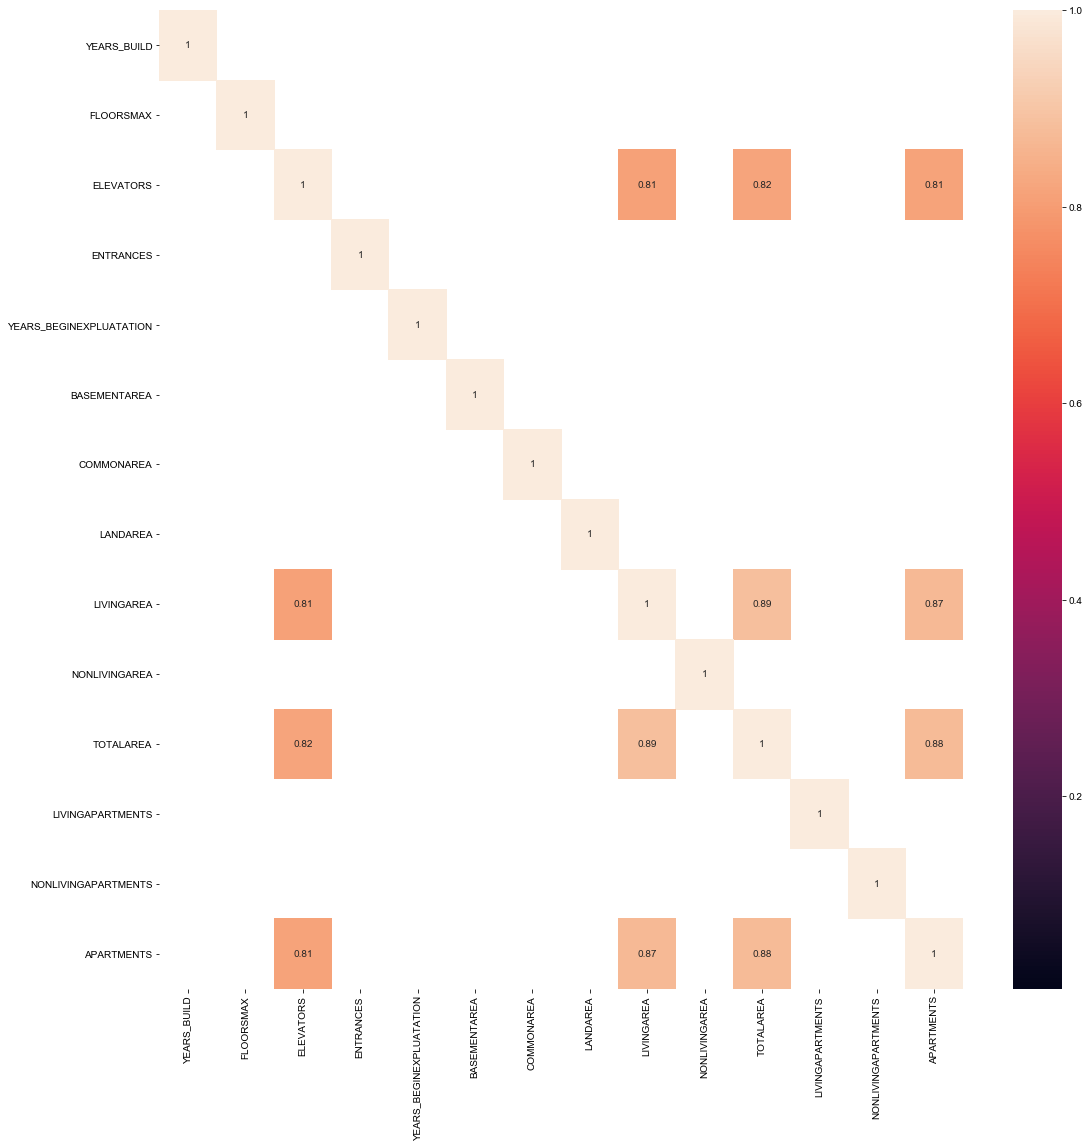

In [21]:
# # 检查剩下的离散中间值中是否还存在高度相关
matir = data.filter(regex=_regex_str).corr()
plt.subplots(figsize = (18,18))
sns.heatmap(matir,mask=matir<=0.8,annot=True)
# 发现，处理之后的中间变量还是存在高度线性相关的变量

In [22]:
print('上面热力图所有高度相关的相关矩阵为：')
data[['TOTALAREA','LIVINGAREA','LIVINGAPARTMENTS','APARTMENTS','ELEVATORS','TARGET']].corr()

上面热力图所有高度相关的相关矩阵为：


,TOTALAREA,LIVINGAREA,LIVINGAPARTMENTS,APARTMENTS,ELEVATORS,TARGET
TOTALAREA,1.000000,0.885708,0.686572,0.875282,0.819636,-0.021943
LIVINGAREA,0.885708,1.000000,0.687337,0.868732,0.811056,-0.020276
LIVINGAPARTMENTS,0.686572,0.687337,1.000000,0.761765,0.673806,-0.013090
APARTMENTS,0.875282,0.868732,0.761765,1.000000,0.814461,-0.019336
ELEVATORS,0.819636,0.811056,0.673806,0.814461,1.000000,-0.021745
TARGET,-0.021943,-0.020276,-0.013090,-0.019336,-0.021745,1.000000


In [23]:
data.shape

(307511, 92)

In [24]:
from sklearn.decomposition import PCA
pca=PCA(n_components=1)
new_ = pca.fit_transform(data[['TOTALAREA','LIVINGAREA','LIVINGAPARTMENTS','APARTMENTS','ELEVATORS']])
data['new'] = new_
# data.drop('new',axis=1,inplace=True)

In [25]:
(data[['new','TARGET']]).corr()
# 提高了相关度

,new,TARGET
new,1.00000,-0.02194
TARGET,-0.02194,1.00000


In [26]:
# 删除多余的特征
data.drop(['TOTALAREA','LIVINGAREA','LIVINGAPARTMENTS','APARTMENTS','ELEVATORS'],axis=1,inplace=True)
data.shape

(307511, 88)

<center> --- 到此处理完所有中间变量 --- </center>

## 处理缺失较多的非中间变量
* EXT_SOURCE_1
* OWN_CAR_AGE

In [27]:
# 计算连续变量 EXT_SOURCE_1 与TARGET的相关性

print('不填补空值，计算相关性：')
data[['EXT_SOURCE_1','TARGET']].corr()

_mean = data['EXT_SOURCE_1'].mean()
print('将空值使用平均值{}填补，相关性：'.format(_mean))
data[['EXT_SOURCE_1','TARGET']].fillna(_mean).corr()

print('将空值使用0进行填补，相关性：')
data[['EXT_SOURCE_1','TARGET']].fillna(0).corr()

print('填补后相关性反而降低，故使用均值填补 EXT_SOURCE_1 的空值')
data['EXT_SOURCE_1'].fillna(_mean,inplace=True)


不填补空值，计算相关性：


,EXT_SOURCE_1,TARGET
EXT_SOURCE_1,1.000000,-0.155317
TARGET,-0.155317,1.000000


将空值使用平均值0.5021298056566625填补，相关性：


,EXT_SOURCE_1,TARGET
EXT_SOURCE_1,1.000000,-0.099152
TARGET,-0.099152,1.000000


将空值使用0进行填补，相关性：


,EXT_SOURCE_1,TARGET
EXT_SOURCE_1,1.000000,-0.064698
TARGET,-0.064698,1.000000


填补后相关性反而降低，故使用均值填补 EXT_SOURCE_1 的空值


In [55]:
# 由于 OWN_CAR_AGE 缺失超过一半，而 OWN_CAR_AGE 的缺失很可能与 OWN_CAR_AGE = 'N' 有关，后面可能会误删此数据，故先进行处理
# 对私家车信息进行处理
tmp = data[data['FLAG_OWN_CAR']=='Y']
print('为有车，但车龄为 NaN 有{}条'.format( tmp['OWN_CAR_AGE'].isnull().sum() ))
df_t = tmp[tmp['OWN_CAR_AGE'].isnull()][['OWN_CAR_AGE','FLAG_OWN_CAR']]
df_t

print('删除这五行')
data.drop(df_t.index,axis=0,inplace=True)

为有车，但车龄为 NaN 有5条


,OWN_CAR_AGE,FLAG_OWN_CAR
30897,NaN,Y
181231,NaN,Y
217549,NaN,Y
229867,NaN,Y
236868,NaN,Y


In [58]:
# 现在所有空值都是没有车的，将空值替换为-1（有车且为0时表示车不满一个月）
data['OWN_CAR_AGE'].fillna(-1,inplace=True)
# 删除 FLAG_OWN_CAR ，此时 OWN_CAR_AGE 小于0可代表 FLAG_OWN_CAR 为'N'的数据，OWN_CAR_AGE 大于等于0可代表 FLAG_OWN_CAR 为'Y'的数据
data.drop('FLAG_OWN_CAR',axis=1,inplace = True)
data.shape

(307506, 87)

## 处理缺失较少的变量

In [59]:
# 缺失少于0.1
# 剩下的含空值变量都为缺失较少的变量，因为缺失较多的数据已经在上面处理完了

examine_missing_data(data) # 查看当前缺失值的情况

# 缺失非常少的，直接删除行
data.dropna(subset = ['AMT_ANNUITY','DAYS_LAST_PHONE_CHANGE'], axis=0, inplace=True)
data.index = range(data.shape[0]) # 恢复索引

数据总共有87个特征，其中存在缺失值的特征数为18


,缺失值数量,缺失值占比(%)
OCCUPATION_TYPE,96390,31.345730
EXT_SOURCE_3,60964,19.825304
AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501850
AMT_REQ_CREDIT_BUREAU_QRT,41519,13.501850
AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501850
...,...,...
EXT_SOURCE_2,660,0.214630
AMT_GOODS_PRICE,278,0.090405
AMT_ANNUITY,12,0.003902
CNT_FAM_MEMBERS,2,0.000650


In [60]:
# 剩下的其他缺失变量
cols = data.columns[data.isnull().sum()>0]
# 查看每种缺失变量的类型
data[cols].dtypes.value_counts()
# 经过查看，只有 object 变量才符合离散数据特点，其他混在 float 类型中但是取值种类小于等于15的均为 ‘XX的次数’，属于整数型连续变量，空值使用平均值的四舍五入进行填补
# 获取 obj 变量类型
obj_c = data[cols].select_dtypes(['object']).columns
ft_c = data[cols].select_dtypes(['float64']).columns
for i in obj_c:
    data[i].fillna(data[i].mode()[0],inplace=True)
for i in ft_c:
    data[i].fillna(data[i].mean(),inplace=True)

float64    14
object      2
dtype: int64

In [61]:
data.isnull().sum().sum()
# 填补完所有空值

0

<center>--- 到此填补完所有空值 ---</center>

## object 数据数值化
object 数值化，需要进行热编码，所以特征会快速增加

In [62]:
data.shape

(307493, 87)

In [34]:
# 统计数据集中变量类型
data.dtypes.value_counts()

int64      40
float64    32
object     14
dtype: int64

In [104]:
obj_c = data.select_dtypes(['object']).columns
print('离散值为：',obj_c)
print('不同离散值的熵值表（倒序）')
gr_df = pd.DataFrame(index = obj_c,columns=['gain','value_count'])
for i in obj_c:
    gr_df.loc[i,'gain']=gr(data,i,'TARGET')
    gr_df.loc[i,'value_count']=len(data[i].unique())
pd_all()
gr_df.sort_values(by='gain',ascending=False)
pd_def()

离散值为： Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'FONDKAPREMONT', 'HOUSETYPE',
       'WALLSMATERIAL', 'EMERGENCYSTATE'],
      dtype='object')
不同离散值的熵值表（倒序）


,gain,value_count
NAME_EDUCATION_TYPE,0.00236608,5
CODE_GENDER,0.00226055,3
NAME_INCOME_TYPE,0.00179418,8
NAME_CONTRACT_TYPE,0.00167833,2
NAME_HOUSING_TYPE,0.00122621,6
OCCUPATION_TYPE,0.000992887,18
ORGANIZATION_TYPE,0.000938601,58
WALLSMATERIAL,0.000785282,8
NAME_FAMILY_STATUS,0.000718486,6
FONDKAPREMONT,0.00054107,5


In [101]:
# # 删除增益率非常小的变量
data['NAME_TYPE_SUITE'].value_counts() # 人员陪同情况，作用不大
data.drop('NAME_TYPE_SUITE',axis=1,inplace=True)

# 客户是否有不动产
print('客户是否有不动产，这个反映了客户的资产状况，但是从下图看出似乎对违约情况无参考价值')
data['FLAG_OWN_REALTY'].value_counts() 
data.drop('FLAG_OWN_REALTY',axis=1,inplace=True)
draw_pie(data,'FLAG_OWN_REALTY','TARGET')

data['WEEKDAY_APPR_PROCESS_START'].value_counts()  # 第几周申请，作用不大
data.drop('WEEKDAY_APPR_PROCESS_START',axis=1,inplace=True)

TUESDAY      53900
WEDNESDAY    51927
MONDAY       50711
THURSDAY     50591
FRIDAY       50333
SATURDAY     33850
SUNDAY       16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

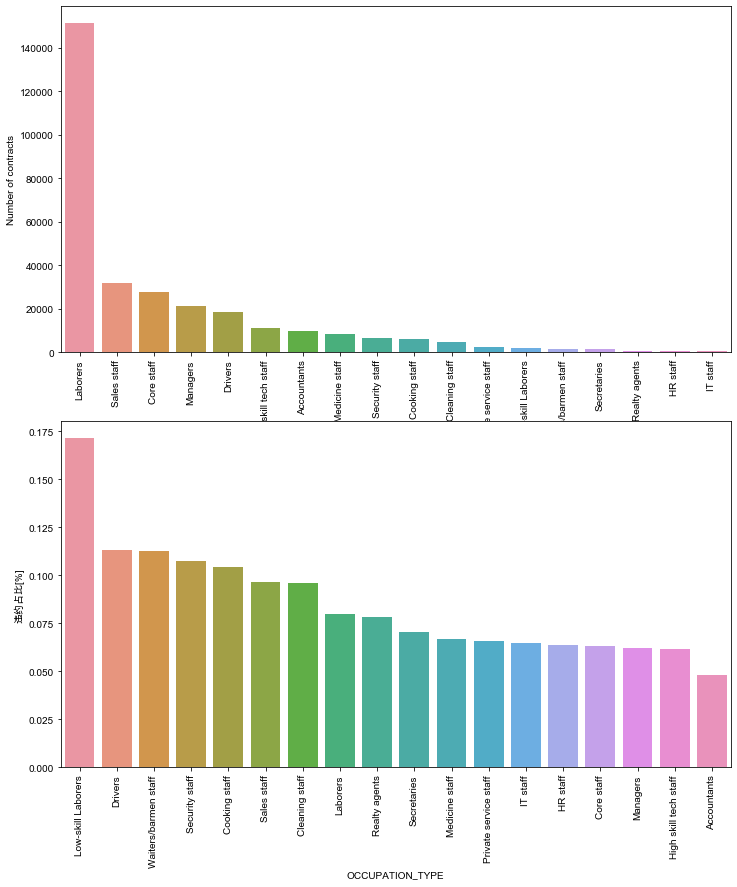

,OCCUPATION_TYPE,TARGET
9,Low-skill Laborers,0.171524
4,Drivers,0.113273
17,Waiters/barmen staff,0.112760
16,Security staff,0.107440
2,Cooking staff,0.104458
14,Sales staff,0.096321
1,Cleaning staff,0.096067
8,Laborers,0.079935
13,Realty agents,0.078562
15,Secretaries,0.070552


通过上图发现，从职业来看，越相对收入较低、不稳定的职业违约率越高，比如低廉劳动力、司机、理发师，而像会计、高科技员工、管理层等具有稳定高收入的职业违约率较低


In [125]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    app_train_domain=data.copy()
    temp = app_train_domain[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # 计算该特征的每种取值的信贷违约的占比（TARGET = 1）
    cat_perc = app_train_domain[[feature, 'TARGET']].groupby([feature],as_index=False).mean() #计算该特征的每种取值 TARGET 的均值，即为对应的违约率
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True) # 对占比进行排序
    


    if(horizontal_layout): # x轴文字是否水平
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6)) # 绘制两个图
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel") # 设置颜色系
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation): # 是否带图标
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('违约占比[%]', fontsize=10) 
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show()
    return cat_perc


ocp_order = plot_stats('OCCUPATION_TYPE',True, False) # 获取不同职业违约率的排序表

print('通过上图发现，从职业来看，越相对收入较低、不稳定的职业违约率越高，比如低廉劳动力、司机、理发师，而像会计、高科技员工、管理层等具有稳定高收入的职业违约率较低')

In [146]:

# 尝试对职业特征进行合并，划分阶层，简化热编码特征
staff_1 = ['Accountants','High skill tech staff','Managers','Core staff','IT staff'] # 高薪，稳定
staff_2 = ['HR staff','Private service staff','Medicine staff','Secretaries','Realty agents'] # 中薪，稳定 / 高薪，不太稳定
staff_3 = ['Laborers','Cleaning staff','Sales staff','Cooking staff','Security staff','Waiters/barmen staff','Drivers','Low-skill Laborers'] # 低薪，不稳定

# 根据职业类型划分阶层，此特征中数值有一定的等级意义，用进行热编码
def occupation_class(x):
    if x in staff_1:
        return 1
    elif x in staff_2:
        return 2
    else:
        return 3

data['OCCUPATION_CLASS'] = data['OCCUPATION_TYPE'].apply(lambda x:occupation_class(x))
print('新特征 OCCUPATION_CLASS 的信息增益率为：{}'.format(gr(data,'OCCUPATION_CLASS','TARGET')))
print('原特征 OCCUPATION_TYPE 的信息增益率为{}'.format(gr(data,'OCCUPATION_TYPE','TARGET')))
print('原特征 ORGANIZATION_TYPE 的信息增益率为{}'.format(gr(data,'ORGANIZATION_TYPE','TARGET')))
print('故使用新特征替代就特征')
# ORGANIZATION_TYPE(58) 和 OCCUPATION_TYPE(18) 都表示职业，并且(18)比(58)的增益率要高，所以删除 ORGANIZATION_TYPE
print('删除冗余的职业类型变量，更改为新变量')

新特征 OCCUPATION_CLASS 的信息增益率为：0.001395758871992355
原特征 OCCUPATION_TYPE 的信息增益率为0.0009928874004640116


KeyError: 'ORGANIZATION_TYPE'

In [ ]:
# 删除冗余的职业特征
data.drop('OCCUPATION_TYPE',axis=1,inplace=True)
data.drop('ORGANIZATION_TYPE',axis=1,inplace=True)

In [22]:
data['ORGANIZATION_TYPE']
data['OCCUPATION_TYPE']

0         Business Entity Type 3
1                         School
2                     Government
3         Business Entity Type 3
4                       Religion
                   ...          
307506                  Services
307507                       XNA
307508                    School
307509    Business Entity Type 1
307510    Business Entity Type 3
Name: ORGANIZATION_TYPE, Length: 307511, dtype: object

0            Laborers
1          Core staff
2            Laborers
3            Laborers
4          Core staff
             ...     
307506    Sales staff
307507            NaN
307508       Managers
307509       Laborers
307510       Laborers
Name: OCCUPATION_TYPE, Length: 307511, dtype: object

<center><h2>--- 施工到此处 ---<h2></center>
<hr>